<a href="https://colab.research.google.com/github/Salman1450/CXR-and-MRI/blob/main/DoubleUnet_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install segmentation-models
!pip install tensorflow
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, AveragePooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19,VGG16,ResNet50,InceptionV3

def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def conv_block(x, filters):
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()

    x = inputs
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation="bilinear")(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, 1, padding="same")(inputs)
    x = Activation("sigmoid")(x)
    return x

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []

    x = inputs
    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()

    x = inputs
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation="bilinear")(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def build_model(input_shape):
    inputs = Input(input_shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    output1 = output_block(x)

    x = inputs * output1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    output2 = output_block(x)

    outputs = Concatenate()([output1, output2])
    model = Model(inputs, outputs)
    return model


if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_model(input_shape)
    model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 11hcgbRcs_9mV1QkiDq8Eb6FKENQClI2f
!pip install patool
import patoolib
patoolib.extract_archive('archive.zip')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11hcgbRcs_9mV1QkiDq8Eb6FKENQClI2f
To: /content/archive.zip
100% 327M/327M [00:02<00:00, 111MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.0 MB/s eta 0:00:00
patool: Extracting archive.zip ...
patool: running /usr/bin/7z x -o./Unpack_9q52f0xo -- archive.zip
patool: ... archive.zip extracted to `archive' (multiple files in root).


'archive'

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split



""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape,Input
from tensorflow import float32
from keras.layers import Lambda




def iou_now(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def iou(y_true, y_pred):
    y_pred1, y_pred2 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    iou1 = iou_now(y_true, y_pred1)
    iou2 = iou_now(y_true, y_pred2)
    return (iou1 + iou2) / 2


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_pred_1, y_pred_2 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred_1 = tf.keras.layers.Flatten()(y_pred_1)
    intersection_1 = tf.reduce_sum(y_true * y_pred_1)
    dice_1 = (2. * intersection_1 + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_1) + smooth)
    
    y_pred_2 = tf.keras.layers.Flatten()(y_pred_2)
    intersection_2 = tf.reduce_sum(y_true * y_pred_2)
    dice_2 = (2. * intersection_2 + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_2) + smooth)
    
    return (dice_1 + dice_2) / 2

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

     

def recall(y_true, y_pred):
    y_pred1, y_pred2 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    y_pred1 = tf.keras.layers.Flatten()(y_pred1)
    y_pred2 = tf.keras.layers.Flatten()(y_pred2)

    y_true = tf.keras.layers.Flatten()(y_true)
    
    true_positives1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred1, 1)), tf.float32))
    true_positives2 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred2, 1)), tf.float32))

    possible_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), tf.float32))

    recall1 = true_positives1 / (possible_positives + 1e-15)
    recall2 = true_positives2 / (possible_positives + 1e-15)

    recall = (recall1 + recall2) / 2
    return recall

def precision(y_true, y_pred):
    y_pred1, y_pred2 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    y_pred1 = tf.keras.layers.Flatten()(y_pred1)
    y_pred2 = tf.keras.layers.Flatten()(y_pred2)

    y_true = tf.keras.layers.Flatten()(y_true)
    
    true_positives1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred1, 1)), tf.float32))
    true_positives2 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred2, 1)), tf.float32))

    predicted_positives1 = tf.reduce_sum(tf.cast(tf.equal(y_pred1, 1), tf.float32))
    predicted_positives2 = tf.reduce_sum(tf.cast(tf.equal(y_pred2, 1), tf.float32))

    precision1 = true_positives1 / (predicted_positives1 + 1e-15)
    precision2 = true_positives2 / (predicted_positives2 + 1e-15)

    precision = (precision1 + precision2) / 2
    return precision




In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "Double_Unet_model.h5")
    csv_path = os.path.join("files", "Double_UNET_data.csv")

    """ Dataset """
    dataset_path = "/content/archive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")
   

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    metrics = [dice_coef, iou,recall, precision]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )
     

Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.9149 - accuracy: 0.8335 - dice_coef: 0.0851 - iou: 0.0446 - recall: 3.6273e-05 - precision: 0.0087
Epoch 1: val_loss improved from inf to 0.93475, saving model to files/Double_Unet_model.h5
115/115 [==============================] - 165s 1s/step - loss: 0.9149 - accuracy: 0.8335 - dice_coef: 0.0851 - iou: 0.0446 - recall: 3.6273e-05 - precision: 0.0087 - val_loss: 0.9347 - val_accuracy: 0.4444 - val_dice_coef: 0.0650 - val_iou: 0.0337 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.8797 - accuracy: 0.9242 - dice_coef: 0.1203 - iou: 0.0642 - recall: 9.4587e-04 - precision: 0.0739
Epoch 2: val_loss improved from 0.93475 to 0.92234, saving model to files/Double_Unet_model.h5
115/115 [==============================] - 150s 1s/step - loss: 0.8797 - accuracy: 0.9242 - dice_coe

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
import matplotlib.pyplot as plt
 
if __name__ == "__main__":
    create_dir("output")
    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss,'recall':recall,"precision":precision}):
        model = tf.keras.models.load_model("/content/files/Double_Unet_model.h5")
    i=0
    """ Predicting the mask """
    for x, y  in tqdm(zip(test_x,test_y), total=len(test_x)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        img = cv2.imread(x, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        x = img/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        img_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        img_y = cv2.resize(img_y, (W, H))
        img_y = np.expand_dims(img_y, axis=-1)  ## (512, 512, 1)
        img_y = np.concatenate([img_y, img_y, img_y], axis=-1)  ## (512, 512, 3)

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)
        y_pred_1, y_pred_2 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
        """ Saving the predicted mask along with the image and GT """
        y_pred_1 = np.concatenate([y_pred_1, y_pred_1, y_pred_1], axis=-1)
        #y_pred_1 = np.where(y_pred_1>0,255,y_pred_1)
        y_pred_2 = np.concatenate([y_pred_2, y_pred_2, y_pred_2], axis=-1)
        #y_pred_2 = np.where(y_pred_2>0,255,y_pred_2)
        sep_line = np.ones((H, 10, 3)) * 255

        output_image = np.concatenate([img, sep_line, img_y, sep_line, y_pred_1*255,sep_line, y_pred_2*255], axis=1)
        #cat_image = np.concatenate([sep_line,y_pred*255,sep_line], axis=1) # this line for just the output segment
        #cat_image = np.concatenate([ori_x,sep_line,y_pred*255], axis=1) # this line for just the output segment and the test image
        cv2.imwrite(f"/content/output/{i}.png", output_image)
        i=i+1
     

  0%|          | 0/612 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 1/612 [00:01<15:26,  1.52s/it]

1/1 [==============================] - 0s 76ms/step


  0%|          | 2/612 [00:01<07:07,  1.43it/s]

1/1 [==============================] - 0s 73ms/step


  0%|          | 3/612 [00:01<04:25,  2.29it/s]

1/1 [==============================] - 0s 78ms/step


  1%|          | 4/612 [00:01<03:10,  3.19it/s]

1/1 [==============================] - 0s 72ms/step


  1%|          | 5/612 [00:02<02:47,  3.62it/s]

1/1 [==============================] - 0s 77ms/step


  1%|          | 6/612 [00:02<02:16,  4.43it/s]

1/1 [==============================] - 0s 73ms/step


  1%|          | 7/612 [00:02<01:56,  5.20it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▏         | 8/612 [00:02<01:43,  5.83it/s]

1/1 [==============================] - 0s 69ms/step


  1%|▏         | 9/612 [00:02<01:32,  6.49it/s]

1/1 [==============================] - 0s 66ms/step


  2%|▏         | 10/612 [00:02<01:25,  7.04it/s]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 11/612 [00:02<01:21,  7.42it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 12/612 [00:02<01:18,  7.62it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 13/612 [00:03<01:15,  7.94it/s]

1/1 [==============================] - 0s 72ms/step


  2%|▏         | 14/612 [00:03<01:15,  7.90it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 15/612 [00:03<01:13,  8.17it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 16/612 [00:03<01:11,  8.39it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 17/612 [00:03<01:11,  8.34it/s]

1/1 [==============================] - 0s 72ms/step


  3%|▎         | 18/612 [00:03<01:10,  8.41it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 19/612 [00:03<01:09,  8.56it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 20/612 [00:03<01:08,  8.62it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 21/612 [00:03<01:08,  8.68it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▎         | 22/612 [00:04<01:08,  8.62it/s]

1/1 [==============================] - 0s 68ms/step


  4%|▍         | 23/612 [00:04<01:08,  8.62it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 24/612 [00:04<01:07,  8.66it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 25/612 [00:04<01:07,  8.68it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▍         | 26/612 [00:04<01:06,  8.76it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 27/612 [00:04<01:07,  8.66it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▍         | 28/612 [00:04<01:08,  8.56it/s]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 29/612 [00:04<01:07,  8.58it/s]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 30/612 [00:05<01:07,  8.63it/s]

1/1 [==============================] - 0s 68ms/step


  5%|▌         | 31/612 [00:05<01:07,  8.61it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▌         | 32/612 [00:05<01:08,  8.41it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▌         | 33/612 [00:05<01:07,  8.54it/s]

1/1 [==============================] - 0s 71ms/step


  6%|▌         | 34/612 [00:05<01:08,  8.46it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 35/612 [00:05<01:07,  8.57it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 36/612 [00:05<01:06,  8.62it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 37/612 [00:05<01:06,  8.67it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▌         | 38/612 [00:05<01:07,  8.55it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▋         | 39/612 [00:06<01:07,  8.43it/s]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 40/612 [00:06<01:09,  8.27it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 41/612 [00:06<01:07,  8.44it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 42/612 [00:06<01:07,  8.51it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 43/612 [00:06<01:06,  8.53it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 44/612 [00:06<01:06,  8.49it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 45/612 [00:06<01:06,  8.55it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 46/612 [00:06<01:05,  8.59it/s]

1/1 [==============================] - 0s 70ms/step


  8%|▊         | 47/612 [00:07<01:05,  8.57it/s]

1/1 [==============================] - 0s 67ms/step


  8%|▊         | 48/612 [00:07<01:06,  8.48it/s]

1/1 [==============================] - 0s 71ms/step


  8%|▊         | 49/612 [00:07<01:19,  7.07it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 50/612 [00:07<01:15,  7.46it/s]

1/1 [==============================] - 0s 84ms/step


  8%|▊         | 51/612 [00:07<01:15,  7.39it/s]

1/1 [==============================] - 0s 80ms/step


  8%|▊         | 52/612 [00:07<01:17,  7.19it/s]

1/1 [==============================] - 0s 81ms/step


  9%|▊         | 53/612 [00:07<01:19,  7.02it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▉         | 54/612 [00:08<01:32,  6.06it/s]

1/1 [==============================] - 0s 92ms/step


  9%|▉         | 55/612 [00:08<01:41,  5.49it/s]

1/1 [==============================] - 0s 79ms/step


  9%|▉         | 56/612 [00:08<01:34,  5.86it/s]

1/1 [==============================] - 0s 79ms/step


  9%|▉         | 57/612 [00:08<01:42,  5.42it/s]

1/1 [==============================] - 0s 82ms/step


  9%|▉         | 58/612 [00:08<01:39,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


 10%|▉         | 59/612 [00:09<01:46,  5.21it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 60/612 [00:09<01:40,  5.52it/s]

1/1 [==============================] - 0s 93ms/step


 10%|▉         | 61/612 [00:09<01:35,  5.75it/s]

1/1 [==============================] - 0s 96ms/step


 10%|█         | 62/612 [00:09<01:34,  5.82it/s]

1/1 [==============================] - 0s 73ms/step


 10%|█         | 63/612 [00:09<01:26,  6.35it/s]

1/1 [==============================] - 0s 71ms/step


 10%|█         | 64/612 [00:09<01:20,  6.84it/s]

1/1 [==============================] - 0s 73ms/step


 11%|█         | 65/612 [00:09<01:15,  7.21it/s]

1/1 [==============================] - 0s 85ms/step


 11%|█         | 66/612 [00:10<01:26,  6.32it/s]

1/1 [==============================] - 0s 71ms/step


 11%|█         | 67/612 [00:10<01:20,  6.81it/s]

1/1 [==============================] - 0s 78ms/step


 11%|█         | 68/612 [00:10<01:16,  7.07it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█▏        | 69/612 [00:10<01:12,  7.49it/s]

1/1 [==============================] - 0s 70ms/step


 11%|█▏        | 70/612 [00:10<01:09,  7.78it/s]

1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 71/612 [00:10<01:07,  8.01it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 72/612 [00:10<01:06,  8.18it/s]

1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 73/612 [00:10<01:05,  8.27it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 74/612 [00:11<01:03,  8.43it/s]

1/1 [==============================] - 0s 72ms/step


 12%|█▏        | 75/612 [00:11<01:04,  8.38it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 76/612 [00:11<01:03,  8.46it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 77/612 [00:11<01:16,  7.00it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 78/612 [00:11<01:13,  7.25it/s]

1/1 [==============================] - 0s 140ms/step


 13%|█▎        | 79/612 [00:11<01:33,  5.71it/s]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 80/612 [00:12<01:58,  4.50it/s]

1/1 [==============================] - 0s 159ms/step


 13%|█▎        | 81/612 [00:12<02:30,  3.52it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 82/612 [00:12<02:21,  3.73it/s]

1/1 [==============================] - 0s 71ms/step


 14%|█▎        | 83/612 [00:13<01:57,  4.50it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▎        | 84/612 [00:13<01:41,  5.23it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 85/612 [00:13<01:38,  5.35it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 86/612 [00:13<02:02,  4.28it/s]

1/1 [==============================] - 0s 140ms/step


 14%|█▍        | 87/612 [00:13<02:18,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█▍        | 88/612 [00:14<02:14,  3.90it/s]

1/1 [==============================] - 0s 72ms/step


 15%|█▍        | 89/612 [00:14<01:52,  4.63it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▍        | 90/612 [00:14<01:39,  5.26it/s]

1/1 [==============================] - 0s 72ms/step


 15%|█▍        | 91/612 [00:14<01:28,  5.91it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▌        | 92/612 [00:14<01:19,  6.52it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▌        | 93/612 [00:14<01:14,  7.01it/s]

1/1 [==============================] - 0s 66ms/step


 15%|█▌        | 94/612 [00:14<01:10,  7.40it/s]

1/1 [==============================] - 0s 68ms/step


 16%|█▌        | 95/612 [00:15<01:06,  7.73it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 96/612 [00:15<01:05,  7.90it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 97/612 [00:15<01:03,  8.10it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 98/612 [00:15<01:03,  8.13it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 99/612 [00:15<01:03,  8.12it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▋        | 100/612 [00:15<01:01,  8.32it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█▋        | 101/612 [00:15<01:01,  8.31it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 102/612 [00:15<01:00,  8.39it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 103/612 [00:16<01:00,  8.47it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 104/612 [00:16<00:59,  8.57it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 105/612 [00:16<00:58,  8.63it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█▋        | 106/612 [00:16<00:58,  8.68it/s]

1/1 [==============================] - 0s 72ms/step


 17%|█▋        | 107/612 [00:16<00:59,  8.55it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 108/612 [00:16<00:58,  8.56it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 109/612 [00:16<00:59,  8.46it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 110/612 [00:17<02:19,  3.61it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█▊        | 111/612 [00:17<02:06,  3.95it/s]

1/1 [==============================] - 0s 75ms/step


 18%|█▊        | 112/612 [00:17<01:47,  4.64it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 113/612 [00:17<01:34,  5.28it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▊        | 114/612 [00:17<01:23,  5.94it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▉        | 115/612 [00:18<01:16,  6.51it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 116/612 [00:18<01:11,  6.94it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 117/612 [00:18<01:07,  7.32it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 118/612 [00:18<01:04,  7.61it/s]

1/1 [==============================] - 0s 76ms/step


 19%|█▉        | 119/612 [00:18<01:05,  7.55it/s]

1/1 [==============================] - 0s 69ms/step


 20%|█▉        | 120/612 [00:18<01:14,  6.58it/s]

1/1 [==============================] - 0s 70ms/step


 20%|█▉        | 121/612 [00:18<01:09,  7.02it/s]

1/1 [==============================] - 0s 70ms/step


 20%|█▉        | 122/612 [00:18<01:06,  7.36it/s]

1/1 [==============================] - 0s 69ms/step


 20%|██        | 123/612 [00:19<01:03,  7.68it/s]

1/1 [==============================] - 0s 76ms/step


 20%|██        | 124/612 [00:19<01:03,  7.68it/s]

1/1 [==============================] - 0s 68ms/step


 20%|██        | 125/612 [00:19<01:13,  6.63it/s]

1/1 [==============================] - 0s 70ms/step


 21%|██        | 126/612 [00:19<01:08,  7.05it/s]

1/1 [==============================] - 0s 97ms/step


 21%|██        | 127/612 [00:19<01:09,  6.99it/s]

1/1 [==============================] - 0s 84ms/step


 21%|██        | 128/612 [00:19<01:21,  5.93it/s]

1/1 [==============================] - 0s 81ms/step


 21%|██        | 129/612 [00:20<01:18,  6.12it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 130/612 [00:20<01:27,  5.50it/s]

1/1 [==============================] - 0s 87ms/step


 21%|██▏       | 131/612 [00:20<01:23,  5.75it/s]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 132/612 [00:20<01:32,  5.21it/s]

1/1 [==============================] - 0s 87ms/step


 22%|██▏       | 133/612 [00:20<01:36,  4.95it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 134/612 [00:21<01:32,  5.16it/s]

1/1 [==============================] - 0s 86ms/step


 22%|██▏       | 135/612 [00:21<01:26,  5.54it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 136/612 [00:21<01:22,  5.74it/s]

1/1 [==============================] - 0s 86ms/step


 22%|██▏       | 137/612 [00:21<01:20,  5.94it/s]

1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 138/612 [00:21<01:16,  6.20it/s]

1/1 [==============================] - 0s 74ms/step


 23%|██▎       | 139/612 [00:21<01:22,  5.70it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 140/612 [00:22<01:26,  5.46it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 141/612 [00:22<01:18,  5.98it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 142/612 [00:22<01:12,  6.50it/s]

1/1 [==============================] - 0s 73ms/step


 23%|██▎       | 143/612 [00:22<01:08,  6.88it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██▎       | 144/612 [00:22<01:15,  6.19it/s]

1/1 [==============================] - 0s 72ms/step


 24%|██▎       | 145/612 [00:22<01:20,  5.79it/s]

1/1 [==============================] - 0s 74ms/step


 24%|██▍       | 146/612 [00:23<01:13,  6.32it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 147/612 [00:23<01:19,  5.84it/s]

1/1 [==============================] - 0s 78ms/step


 24%|██▍       | 148/612 [00:23<01:23,  5.58it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▍       | 149/612 [00:23<01:27,  5.30it/s]

1/1 [==============================] - 0s 75ms/step


 25%|██▍       | 150/612 [00:23<01:18,  5.87it/s]

1/1 [==============================] - 0s 76ms/step


 25%|██▍       | 151/612 [00:23<01:12,  6.37it/s]

1/1 [==============================] - 0s 72ms/step


 25%|██▍       | 152/612 [00:24<01:07,  6.80it/s]

1/1 [==============================] - 0s 73ms/step


 25%|██▌       | 153/612 [00:24<01:04,  7.06it/s]

1/1 [==============================] - 0s 72ms/step


 25%|██▌       | 154/612 [00:24<01:12,  6.30it/s]

1/1 [==============================] - 0s 68ms/step


 25%|██▌       | 155/612 [00:24<01:07,  6.80it/s]

1/1 [==============================] - 0s 66ms/step


 25%|██▌       | 156/612 [00:24<01:02,  7.24it/s]

1/1 [==============================] - 0s 82ms/step


 26%|██▌       | 157/612 [00:24<01:01,  7.38it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 158/612 [00:24<00:58,  7.70it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 159/612 [00:24<00:58,  7.75it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 160/612 [00:25<00:56,  7.96it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▋       | 161/612 [00:25<00:55,  8.09it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▋       | 162/612 [00:25<00:55,  8.16it/s]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 163/612 [00:25<00:54,  8.21it/s]

1/1 [==============================] - 0s 66ms/step


 27%|██▋       | 164/612 [00:25<00:54,  8.23it/s]

1/1 [==============================] - 0s 74ms/step


 27%|██▋       | 165/612 [00:25<01:04,  6.93it/s]

1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 166/612 [00:25<01:01,  7.31it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 167/612 [00:25<00:58,  7.64it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 168/612 [00:26<00:56,  7.84it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██▊       | 169/612 [00:26<00:56,  7.85it/s]

1/1 [==============================] - 0s 69ms/step


 28%|██▊       | 170/612 [00:26<00:55,  7.96it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 171/612 [00:26<01:05,  6.75it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 172/612 [00:26<01:01,  7.12it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██▊       | 173/612 [00:26<00:58,  7.49it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 174/612 [00:26<00:56,  7.71it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▊       | 175/612 [00:27<01:05,  6.66it/s]

1/1 [==============================] - 0s 75ms/step


 29%|██▉       | 176/612 [00:27<01:02,  6.99it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▉       | 177/612 [00:27<00:59,  7.31it/s]

1/1 [==============================] - 0s 69ms/step


 29%|██▉       | 178/612 [00:27<00:57,  7.59it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▉       | 179/612 [00:27<00:56,  7.70it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▉       | 180/612 [00:27<00:54,  7.90it/s]

1/1 [==============================] - 0s 67ms/step


 30%|██▉       | 181/612 [00:27<00:53,  7.98it/s]

1/1 [==============================] - 0s 70ms/step


 30%|██▉       | 182/612 [00:27<00:53,  8.08it/s]

1/1 [==============================] - 0s 68ms/step


 30%|██▉       | 183/612 [00:28<00:52,  8.18it/s]

1/1 [==============================] - 0s 73ms/step


 30%|███       | 184/612 [00:28<01:02,  6.88it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 185/612 [00:28<00:58,  7.26it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 186/612 [00:28<00:56,  7.53it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███       | 187/612 [00:28<00:54,  7.78it/s]

1/1 [==============================] - 0s 74ms/step


 31%|███       | 188/612 [00:28<00:54,  7.83it/s]

1/1 [==============================] - 0s 74ms/step


 31%|███       | 189/612 [00:28<00:54,  7.75it/s]

1/1 [==============================] - 0s 70ms/step


 31%|███       | 190/612 [00:29<00:53,  7.86it/s]

1/1 [==============================] - 0s 69ms/step


 31%|███       | 191/612 [00:29<00:52,  8.00it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███▏      | 192/612 [00:29<00:52,  8.06it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 193/612 [00:29<00:51,  8.08it/s]

1/1 [==============================] - 0s 70ms/step


 32%|███▏      | 194/612 [00:29<00:51,  8.13it/s]

1/1 [==============================] - 0s 69ms/step


 32%|███▏      | 195/612 [00:29<00:51,  8.16it/s]

1/1 [==============================] - 0s 74ms/step


 32%|███▏      | 196/612 [00:29<00:51,  8.15it/s]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 197/612 [00:29<00:50,  8.16it/s]

1/1 [==============================] - 0s 69ms/step


 32%|███▏      | 198/612 [00:29<00:50,  8.22it/s]

1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 199/612 [00:30<00:50,  8.10it/s]

1/1 [==============================] - 0s 73ms/step


 33%|███▎      | 200/612 [00:30<00:50,  8.10it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 201/612 [00:30<00:51,  8.01it/s]

1/1 [==============================] - 0s 75ms/step


 33%|███▎      | 202/612 [00:30<00:52,  7.88it/s]

1/1 [==============================] - 0s 71ms/step


 33%|███▎      | 203/612 [00:30<00:51,  7.90it/s]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 204/612 [00:30<01:00,  6.69it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 205/612 [00:31<01:07,  6.04it/s]

1/1 [==============================] - 0s 72ms/step


 34%|███▎      | 206/612 [00:31<01:02,  6.52it/s]

1/1 [==============================] - 0s 82ms/step


 34%|███▍      | 207/612 [00:31<01:07,  5.96it/s]

1/1 [==============================] - 0s 72ms/step


 34%|███▍      | 208/612 [00:31<01:02,  6.46it/s]

1/1 [==============================] - 0s 75ms/step


 34%|███▍      | 209/612 [00:31<00:58,  6.85it/s]

1/1 [==============================] - 0s 86ms/step


 34%|███▍      | 210/612 [00:31<01:06,  6.04it/s]

1/1 [==============================] - 0s 95ms/step


 34%|███▍      | 211/612 [00:32<01:13,  5.43it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▍      | 212/612 [00:32<01:19,  5.06it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▍      | 213/612 [00:32<01:14,  5.39it/s]

1/1 [==============================] - 0s 103ms/step


 35%|███▍      | 214/612 [00:32<01:19,  4.99it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▌      | 215/612 [00:32<01:21,  4.86it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███▌      | 216/612 [00:33<01:23,  4.74it/s]

1/1 [==============================] - 0s 88ms/step


 35%|███▌      | 217/612 [00:33<01:25,  4.64it/s]

1/1 [==============================] - 0s 95ms/step


 36%|███▌      | 218/612 [00:33<01:26,  4.57it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▌      | 219/612 [00:33<01:17,  5.08it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▌      | 220/612 [00:33<01:18,  5.01it/s]

1/1 [==============================] - 0s 72ms/step


 36%|███▌      | 221/612 [00:34<01:09,  5.65it/s]

1/1 [==============================] - 0s 77ms/step


 36%|███▋      | 222/612 [00:34<01:03,  6.15it/s]

1/1 [==============================] - 0s 72ms/step


 36%|███▋      | 223/612 [00:34<00:58,  6.63it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 224/612 [00:34<00:55,  7.04it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 225/612 [00:34<00:53,  7.29it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 226/612 [00:34<00:51,  7.53it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 227/612 [00:34<00:50,  7.65it/s]

1/1 [==============================] - 0s 69ms/step


 37%|███▋      | 228/612 [00:34<00:50,  7.68it/s]

1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 229/612 [00:35<00:48,  7.83it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 230/612 [00:35<00:49,  7.70it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 231/612 [00:35<00:48,  7.78it/s]

1/1 [==============================] - 0s 70ms/step


 38%|███▊      | 232/612 [00:35<00:56,  6.72it/s]

1/1 [==============================] - 0s 71ms/step


 38%|███▊      | 233/612 [00:35<00:53,  7.05it/s]

1/1 [==============================] - 0s 73ms/step


 38%|███▊      | 234/612 [00:35<00:51,  7.29it/s]

1/1 [==============================] - 0s 76ms/step


 38%|███▊      | 235/612 [00:35<00:58,  6.44it/s]

1/1 [==============================] - 0s 70ms/step


 39%|███▊      | 236/612 [00:36<00:54,  6.91it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▊      | 237/612 [00:36<00:51,  7.26it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 238/612 [00:36<00:49,  7.57it/s]

1/1 [==============================] - 0s 66ms/step


 39%|███▉      | 239/612 [00:36<00:47,  7.81it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 240/612 [00:36<00:47,  7.78it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 241/612 [00:36<00:46,  7.94it/s]

1/1 [==============================] - 0s 70ms/step


 40%|███▉      | 242/612 [00:36<00:46,  7.96it/s]

1/1 [==============================] - 0s 74ms/step


 40%|███▉      | 243/612 [00:36<00:46,  7.90it/s]

1/1 [==============================] - 0s 68ms/step


 40%|███▉      | 244/612 [00:37<00:46,  8.00it/s]

1/1 [==============================] - 0s 70ms/step


 40%|████      | 245/612 [00:37<00:45,  8.14it/s]

1/1 [==============================] - 0s 68ms/step


 40%|████      | 246/612 [00:37<00:44,  8.20it/s]

1/1 [==============================] - 0s 69ms/step


 40%|████      | 247/612 [00:37<00:44,  8.24it/s]

1/1 [==============================] - 0s 71ms/step


 41%|████      | 248/612 [00:37<00:44,  8.21it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████      | 249/612 [00:37<00:43,  8.29it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████      | 250/612 [00:37<00:44,  8.16it/s]

1/1 [==============================] - 0s 73ms/step


 41%|████      | 251/612 [00:37<00:44,  8.07it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████      | 252/612 [00:38<00:43,  8.20it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████▏     | 253/612 [00:38<00:43,  8.27it/s]

1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 254/612 [00:38<00:43,  8.27it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 255/612 [00:38<00:43,  8.24it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 256/612 [00:38<00:51,  6.95it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 257/612 [00:38<00:48,  7.32it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 258/612 [00:38<00:46,  7.61it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 259/612 [00:38<00:45,  7.78it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 260/612 [00:39<00:45,  7.77it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 261/612 [00:39<00:44,  7.88it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 262/612 [00:39<00:51,  6.75it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 263/612 [00:39<00:49,  7.12it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 264/612 [00:39<00:47,  7.36it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 265/612 [00:39<00:45,  7.59it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 266/612 [00:39<00:44,  7.81it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▎     | 267/612 [00:40<00:43,  7.90it/s]

1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 268/612 [00:40<00:43,  7.99it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 269/612 [00:40<00:42,  8.07it/s]

1/1 [==============================] - 0s 68ms/step


 44%|████▍     | 270/612 [00:40<00:42,  7.99it/s]

1/1 [==============================] - 0s 72ms/step


 44%|████▍     | 271/612 [00:40<00:50,  6.78it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 272/612 [00:40<00:47,  7.16it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▍     | 273/612 [00:40<00:45,  7.53it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▍     | 274/612 [00:40<00:44,  7.64it/s]

1/1 [==============================] - 0s 67ms/step


 45%|████▍     | 275/612 [00:41<00:43,  7.80it/s]

1/1 [==============================] - 0s 70ms/step


 45%|████▌     | 276/612 [00:41<00:50,  6.68it/s]

1/1 [==============================] - 0s 68ms/step


 45%|████▌     | 277/612 [00:41<00:47,  7.10it/s]

1/1 [==============================] - 0s 68ms/step


 45%|████▌     | 278/612 [00:41<00:45,  7.38it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████▌     | 279/612 [00:41<00:43,  7.60it/s]

1/1 [==============================] - 0s 69ms/step


 46%|████▌     | 280/612 [00:41<00:42,  7.75it/s]

1/1 [==============================] - 0s 70ms/step


 46%|████▌     | 281/612 [00:41<00:43,  7.69it/s]

1/1 [==============================] - 0s 74ms/step


 46%|████▌     | 282/612 [00:42<00:50,  6.56it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████▌     | 283/612 [00:42<00:47,  6.99it/s]

1/1 [==============================] - 0s 69ms/step


 46%|████▋     | 284/612 [00:42<00:44,  7.32it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 285/612 [00:42<00:43,  7.46it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 286/612 [00:42<00:42,  7.71it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 287/612 [00:42<00:49,  6.58it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 288/612 [00:42<00:46,  7.00it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 289/612 [00:43<00:44,  7.22it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 290/612 [00:43<00:42,  7.51it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 291/612 [00:43<00:41,  7.67it/s]

1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 292/612 [00:43<00:40,  7.89it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 293/612 [00:43<00:39,  8.08it/s]

1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 294/612 [00:43<00:38,  8.20it/s]

1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 295/612 [00:43<00:42,  7.47it/s]

1/1 [==============================] - 0s 80ms/step


 48%|████▊     | 296/612 [00:43<00:45,  7.01it/s]

1/1 [==============================] - 0s 84ms/step


 49%|████▊     | 297/612 [00:44<00:46,  6.73it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▊     | 298/612 [00:44<00:53,  5.85it/s]

1/1 [==============================] - 0s 90ms/step


 49%|████▉     | 299/612 [00:44<00:52,  6.02it/s]

1/1 [==============================] - 0s 97ms/step


 49%|████▉     | 300/612 [00:44<00:57,  5.42it/s]

1/1 [==============================] - 0s 92ms/step


 49%|████▉     | 301/612 [00:44<00:56,  5.48it/s]

1/1 [==============================] - 0s 89ms/step


 49%|████▉     | 302/612 [00:45<00:54,  5.64it/s]

1/1 [==============================] - 0s 85ms/step


 50%|████▉     | 303/612 [00:45<00:53,  5.81it/s]

1/1 [==============================] - 0s 90ms/step


 50%|████▉     | 304/612 [00:45<00:51,  5.99it/s]

1/1 [==============================] - 0s 93ms/step


 50%|████▉     | 305/612 [00:45<00:56,  5.39it/s]

1/1 [==============================] - 0s 88ms/step


 50%|█████     | 306/612 [00:45<00:54,  5.63it/s]

1/1 [==============================] - 0s 75ms/step


 50%|█████     | 307/612 [00:45<00:57,  5.34it/s]

1/1 [==============================] - 0s 71ms/step


 50%|█████     | 308/612 [00:46<00:58,  5.23it/s]

1/1 [==============================] - 0s 71ms/step


 50%|█████     | 309/612 [00:46<00:52,  5.82it/s]

1/1 [==============================] - 0s 74ms/step


 51%|█████     | 310/612 [00:46<00:54,  5.51it/s]

1/1 [==============================] - 0s 73ms/step


 51%|█████     | 311/612 [00:46<00:50,  5.96it/s]

1/1 [==============================] - 0s 72ms/step


 51%|█████     | 312/612 [00:46<00:46,  6.45it/s]

1/1 [==============================] - 0s 73ms/step


 51%|█████     | 313/612 [00:46<00:43,  6.82it/s]

1/1 [==============================] - 0s 72ms/step


 51%|█████▏    | 314/612 [00:47<00:41,  7.11it/s]

1/1 [==============================] - 0s 74ms/step


 51%|█████▏    | 315/612 [00:47<00:40,  7.26it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 316/612 [00:47<00:39,  7.43it/s]

1/1 [==============================] - 0s 74ms/step


 52%|█████▏    | 317/612 [00:47<00:38,  7.57it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 318/612 [00:47<00:40,  7.27it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 319/612 [00:47<00:45,  6.41it/s]

1/1 [==============================] - 0s 67ms/step


 52%|█████▏    | 320/612 [00:47<00:49,  5.94it/s]

1/1 [==============================] - 0s 70ms/step


 52%|█████▏    | 321/612 [00:48<00:46,  6.30it/s]

1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 322/612 [00:48<00:42,  6.76it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████▎    | 323/612 [00:48<00:40,  7.10it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 324/612 [00:48<00:39,  7.35it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 325/612 [00:48<00:37,  7.57it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 326/612 [00:48<00:36,  7.81it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 327/612 [00:48<00:42,  6.71it/s]

1/1 [==============================] - 0s 69ms/step


 54%|█████▎    | 328/612 [00:49<00:46,  6.04it/s]

1/1 [==============================] - 0s 71ms/step


 54%|█████▍    | 329/612 [00:49<00:43,  6.57it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████▍    | 330/612 [00:49<00:40,  6.97it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▍    | 331/612 [00:49<00:39,  7.19it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████▍    | 332/612 [00:49<00:37,  7.43it/s]

1/1 [==============================] - 0s 71ms/step


 54%|█████▍    | 333/612 [00:49<00:36,  7.67it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▍    | 334/612 [00:49<00:35,  7.75it/s]

1/1 [==============================] - 0s 72ms/step


 55%|█████▍    | 335/612 [00:49<00:35,  7.81it/s]

1/1 [==============================] - 0s 76ms/step


 55%|█████▍    | 336/612 [00:50<00:35,  7.69it/s]

1/1 [==============================] - 0s 75ms/step


 55%|█████▌    | 337/612 [00:50<00:35,  7.67it/s]

1/1 [==============================] - 0s 69ms/step


 55%|█████▌    | 338/612 [00:50<00:35,  7.79it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▌    | 339/612 [00:50<00:34,  7.87it/s]

1/1 [==============================] - 0s 73ms/step


 56%|█████▌    | 340/612 [00:50<00:34,  7.84it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 341/612 [00:50<00:34,  7.84it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 342/612 [00:50<00:34,  7.90it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 343/612 [00:50<00:33,  7.92it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████▌    | 344/612 [00:51<00:39,  6.75it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▋    | 345/612 [00:51<00:37,  7.15it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 346/612 [00:51<00:35,  7.43it/s]

1/1 [==============================] - 0s 66ms/step


 57%|█████▋    | 347/612 [00:51<00:34,  7.59it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 348/612 [00:51<00:33,  7.82it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 349/612 [00:51<00:33,  7.91it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 350/612 [00:51<00:32,  8.03it/s]

1/1 [==============================] - 0s 66ms/step


 57%|█████▋    | 351/612 [00:52<00:32,  8.07it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████▊    | 352/612 [00:52<00:37,  6.85it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 353/612 [00:52<00:35,  7.24it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 354/612 [00:52<00:34,  7.47it/s]

1/1 [==============================] - 0s 75ms/step


 58%|█████▊    | 355/612 [00:52<00:34,  7.54it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 356/612 [00:52<00:33,  7.65it/s]

1/1 [==============================] - 0s 70ms/step


 58%|█████▊    | 357/612 [00:52<00:38,  6.59it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████▊    | 358/612 [00:53<00:36,  6.95it/s]

1/1 [==============================] - 0s 75ms/step


 59%|█████▊    | 359/612 [00:53<00:35,  7.08it/s]

1/1 [==============================] - 0s 74ms/step


 59%|█████▉    | 360/612 [00:53<00:34,  7.29it/s]

1/1 [==============================] - 0s 71ms/step


 59%|█████▉    | 361/612 [00:53<00:33,  7.50it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 362/612 [00:53<00:33,  7.50it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████▉    | 363/612 [00:53<00:32,  7.72it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 364/612 [00:53<00:31,  7.76it/s]

1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 365/612 [00:53<00:31,  7.91it/s]

1/1 [==============================] - 0s 76ms/step


 60%|█████▉    | 366/612 [00:54<00:31,  7.87it/s]

1/1 [==============================] - 0s 72ms/step


 60%|█████▉    | 367/612 [00:54<00:31,  7.83it/s]

1/1 [==============================] - 0s 66ms/step


 60%|██████    | 368/612 [00:54<00:30,  7.97it/s]

1/1 [==============================] - 0s 65ms/step


 60%|██████    | 369/612 [00:54<00:35,  6.82it/s]

1/1 [==============================] - 0s 71ms/step


 60%|██████    | 370/612 [00:54<00:33,  7.17it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 371/612 [00:54<00:32,  7.45it/s]

1/1 [==============================] - 0s 79ms/step


 61%|██████    | 372/612 [00:54<00:32,  7.39it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 373/612 [00:55<00:31,  7.58it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 374/612 [00:55<00:30,  7.77it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████▏   | 375/612 [00:55<00:30,  7.85it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████▏   | 376/612 [00:55<00:29,  7.96it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 377/612 [00:55<00:29,  8.10it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 378/612 [00:55<00:28,  8.23it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 379/612 [00:55<00:28,  8.28it/s]

1/1 [==============================] - 0s 95ms/step


 62%|██████▏   | 380/612 [00:55<00:30,  7.64it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 381/612 [00:56<00:31,  7.22it/s]

1/1 [==============================] - 0s 89ms/step


 62%|██████▏   | 382/612 [00:56<00:33,  6.79it/s]

1/1 [==============================] - 0s 83ms/step


 63%|██████▎   | 383/612 [00:56<00:39,  5.86it/s]

1/1 [==============================] - 0s 86ms/step


 63%|██████▎   | 384/612 [00:56<00:42,  5.32it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 385/612 [00:56<00:45,  4.95it/s]

1/1 [==============================] - 0s 83ms/step


 63%|██████▎   | 386/612 [00:57<00:43,  5.24it/s]

1/1 [==============================] - 0s 84ms/step


 63%|██████▎   | 387/612 [00:57<00:41,  5.43it/s]

1/1 [==============================] - 0s 85ms/step


 63%|██████▎   | 388/612 [00:57<00:39,  5.74it/s]

1/1 [==============================] - 0s 91ms/step


 64%|██████▎   | 389/612 [00:57<00:38,  5.80it/s]

1/1 [==============================] - 0s 85ms/step


 64%|██████▎   | 390/612 [00:57<00:41,  5.31it/s]

1/1 [==============================] - 0s 85ms/step


 64%|██████▍   | 391/612 [00:57<00:39,  5.61it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 392/612 [00:58<00:37,  5.90it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████▍   | 393/612 [00:58<00:34,  6.43it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 394/612 [00:58<00:32,  6.76it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 395/612 [00:58<00:30,  7.07it/s]

1/1 [==============================] - 0s 73ms/step


 65%|██████▍   | 396/612 [00:58<00:29,  7.24it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▍   | 397/612 [00:58<00:28,  7.47it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 398/612 [00:58<00:32,  6.57it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▌   | 399/612 [00:59<00:30,  7.01it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▌   | 400/612 [00:59<00:33,  6.26it/s]

1/1 [==============================] - 0s 67ms/step


 66%|██████▌   | 401/612 [00:59<00:31,  6.62it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 402/612 [00:59<00:30,  6.94it/s]

1/1 [==============================] - 0s 67ms/step


 66%|██████▌   | 403/612 [00:59<00:28,  7.26it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 404/612 [00:59<00:27,  7.48it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 405/612 [00:59<00:31,  6.57it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▋   | 406/612 [01:00<00:29,  7.00it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 407/612 [01:00<00:28,  7.24it/s]

1/1 [==============================] - 0s 74ms/step


 67%|██████▋   | 408/612 [01:00<00:31,  6.42it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 409/612 [01:00<00:30,  6.71it/s]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 410/612 [01:00<00:33,  6.02it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 411/612 [01:00<00:35,  5.60it/s]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 412/612 [01:01<00:33,  6.05it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 413/612 [01:01<00:30,  6.59it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 414/612 [01:01<00:28,  6.88it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 415/612 [01:01<00:27,  7.22it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 416/612 [01:01<00:26,  7.44it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 417/612 [01:01<00:25,  7.72it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 418/612 [01:01<00:24,  7.86it/s]

1/1 [==============================] - 0s 72ms/step


 68%|██████▊   | 419/612 [01:01<00:24,  7.89it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▊   | 420/612 [01:02<00:24,  7.95it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 421/612 [01:02<00:28,  6.75it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▉   | 422/612 [01:02<00:31,  6.01it/s]

1/1 [==============================] - 0s 74ms/step


 69%|██████▉   | 423/612 [01:02<00:29,  6.46it/s]

1/1 [==============================] - 0s 71ms/step


 69%|██████▉   | 424/612 [01:02<00:28,  6.59it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▉   | 425/612 [01:02<00:30,  6.04it/s]

1/1 [==============================] - 0s 71ms/step


 70%|██████▉   | 426/612 [01:03<00:28,  6.51it/s]

1/1 [==============================] - 0s 71ms/step


 70%|██████▉   | 427/612 [01:03<00:26,  6.89it/s]

1/1 [==============================] - 0s 67ms/step


 70%|██████▉   | 428/612 [01:03<00:25,  7.23it/s]

1/1 [==============================] - 0s 83ms/step


 70%|███████   | 429/612 [01:03<00:25,  7.21it/s]

1/1 [==============================] - 0s 71ms/step


 70%|███████   | 430/612 [01:03<00:24,  7.44it/s]

1/1 [==============================] - 0s 70ms/step


 70%|███████   | 431/612 [01:03<00:24,  7.52it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 432/612 [01:03<00:23,  7.65it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 433/612 [01:03<00:23,  7.65it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 434/612 [01:04<00:22,  7.80it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 435/612 [01:04<00:22,  7.74it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 436/612 [01:04<00:22,  7.80it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████▏  | 437/612 [01:04<00:22,  7.85it/s]

1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 438/612 [01:04<00:21,  8.00it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 439/612 [01:04<00:21,  8.00it/s]

1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 440/612 [01:04<00:21,  8.10it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 441/612 [01:04<00:21,  8.07it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 442/612 [01:05<00:24,  6.81it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 443/612 [01:05<00:23,  7.08it/s]

1/1 [==============================] - 0s 83ms/step


 73%|███████▎  | 444/612 [01:05<00:23,  7.14it/s]

1/1 [==============================] - 0s 113ms/step


 73%|███████▎  | 445/612 [01:05<00:26,  6.29it/s]

1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 446/612 [01:05<00:33,  5.02it/s]

1/1 [==============================] - 0s 101ms/step


 73%|███████▎  | 447/612 [01:06<00:38,  4.25it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 448/612 [01:06<00:33,  4.89it/s]

1/1 [==============================] - 0s 70ms/step


 73%|███████▎  | 449/612 [01:06<00:29,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▎  | 450/612 [01:06<00:26,  6.13it/s]

1/1 [==============================] - 0s 86ms/step


 74%|███████▎  | 451/612 [01:06<00:26,  5.96it/s]

1/1 [==============================] - 0s 152ms/step


 74%|███████▍  | 452/612 [01:07<00:36,  4.33it/s]

1/1 [==============================] - 0s 82ms/step


 74%|███████▍  | 453/612 [01:07<00:37,  4.20it/s]

1/1 [==============================] - 0s 70ms/step


 74%|███████▍  | 454/612 [01:07<00:35,  4.40it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████▍  | 455/612 [01:07<00:30,  5.12it/s]

1/1 [==============================] - 0s 71ms/step


 75%|███████▍  | 456/612 [01:07<00:27,  5.74it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 457/612 [01:08<00:28,  5.47it/s]

1/1 [==============================] - 0s 83ms/step


 75%|███████▍  | 458/612 [01:08<00:30,  5.12it/s]

1/1 [==============================] - 0s 89ms/step


 75%|███████▌  | 459/612 [01:08<00:28,  5.36it/s]

1/1 [==============================] - 0s 85ms/step


 75%|███████▌  | 460/612 [01:08<00:27,  5.49it/s]

1/1 [==============================] - 0s 84ms/step


 75%|███████▌  | 461/612 [01:08<00:26,  5.71it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████▌  | 462/612 [01:08<00:26,  5.76it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 463/612 [01:09<00:28,  5.15it/s]

1/1 [==============================] - 0s 84ms/step


 76%|███████▌  | 464/612 [01:09<00:26,  5.51it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████▌  | 465/612 [01:09<00:29,  5.06it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████▌  | 466/612 [01:09<00:27,  5.33it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▋  | 467/612 [01:09<00:25,  5.59it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████▋  | 468/612 [01:10<00:25,  5.71it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 469/612 [01:10<00:24,  5.95it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 470/612 [01:10<00:22,  6.34it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 471/612 [01:10<00:20,  6.75it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 472/612 [01:10<00:20,  6.96it/s]

1/1 [==============================] - 0s 82ms/step


 77%|███████▋  | 473/612 [01:10<00:19,  6.99it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 474/612 [01:10<00:19,  7.13it/s]

1/1 [==============================] - 0s 74ms/step


 78%|███████▊  | 475/612 [01:11<00:18,  7.28it/s]

1/1 [==============================] - 0s 71ms/step


 78%|███████▊  | 476/612 [01:11<00:18,  7.43it/s]

1/1 [==============================] - 0s 72ms/step


 78%|███████▊  | 477/612 [01:11<00:17,  7.52it/s]

1/1 [==============================] - 0s 72ms/step


 78%|███████▊  | 478/612 [01:11<00:17,  7.54it/s]

1/1 [==============================] - 0s 72ms/step


 78%|███████▊  | 479/612 [01:11<00:20,  6.57it/s]

1/1 [==============================] - 0s 70ms/step


 78%|███████▊  | 480/612 [01:11<00:19,  6.92it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▊  | 481/612 [01:11<00:18,  7.15it/s]

1/1 [==============================] - 0s 72ms/step


 79%|███████▉  | 482/612 [01:12<00:17,  7.31it/s]

1/1 [==============================] - 0s 73ms/step


 79%|███████▉  | 483/612 [01:12<00:20,  6.29it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▉  | 484/612 [01:12<00:19,  6.70it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▉  | 485/612 [01:12<00:18,  7.03it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 486/612 [01:12<00:17,  7.22it/s]

1/1 [==============================] - 0s 74ms/step


 80%|███████▉  | 487/612 [01:12<00:16,  7.36it/s]

1/1 [==============================] - 0s 70ms/step


 80%|███████▉  | 488/612 [01:12<00:16,  7.59it/s]

1/1 [==============================] - 0s 69ms/step


 80%|███████▉  | 489/612 [01:12<00:16,  7.64it/s]

1/1 [==============================] - 0s 69ms/step


 80%|████████  | 490/612 [01:13<00:15,  7.76it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 491/612 [01:13<00:15,  7.88it/s]

1/1 [==============================] - 0s 75ms/step


 80%|████████  | 492/612 [01:13<00:15,  7.80it/s]

1/1 [==============================] - 0s 68ms/step


 81%|████████  | 493/612 [01:13<00:15,  7.67it/s]

1/1 [==============================] - 0s 73ms/step


 81%|████████  | 494/612 [01:13<00:15,  7.71it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 495/612 [01:13<00:14,  7.83it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 496/612 [01:13<00:14,  7.90it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 497/612 [01:14<00:14,  7.98it/s]

1/1 [==============================] - 0s 69ms/step


 81%|████████▏ | 498/612 [01:14<00:14,  7.96it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 499/612 [01:14<00:14,  8.07it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 500/612 [01:14<00:16,  6.75it/s]

1/1 [==============================] - 0s 71ms/step


 82%|████████▏ | 501/612 [01:14<00:15,  7.07it/s]

1/1 [==============================] - 0s 71ms/step


 82%|████████▏ | 502/612 [01:14<00:15,  7.16it/s]

1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 503/612 [01:14<00:17,  6.36it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████▏ | 504/612 [01:15<00:16,  6.60it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████▎ | 505/612 [01:15<00:15,  6.92it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 506/612 [01:15<00:14,  7.14it/s]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 507/612 [01:15<00:14,  7.28it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 508/612 [01:15<00:13,  7.43it/s]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 509/612 [01:15<00:13,  7.58it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 510/612 [01:15<00:13,  7.65it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 511/612 [01:15<00:13,  7.70it/s]

1/1 [==============================] - 0s 69ms/step


 84%|████████▎ | 512/612 [01:16<00:12,  7.71it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▍ | 513/612 [01:16<00:12,  7.78it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▍ | 514/612 [01:16<00:12,  7.71it/s]

1/1 [==============================] - 0s 67ms/step


 84%|████████▍ | 515/612 [01:16<00:12,  7.78it/s]

1/1 [==============================] - 0s 67ms/step


 84%|████████▍ | 516/612 [01:16<00:12,  7.85it/s]

1/1 [==============================] - 0s 75ms/step


 84%|████████▍ | 517/612 [01:16<00:12,  7.89it/s]

1/1 [==============================] - 0s 69ms/step


 85%|████████▍ | 518/612 [01:16<00:11,  7.92it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 519/612 [01:17<00:13,  6.75it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▍ | 520/612 [01:17<00:15,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▌ | 521/612 [01:17<00:13,  6.58it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 522/612 [01:17<00:12,  6.93it/s]

1/1 [==============================] - 0s 70ms/step


 85%|████████▌ | 523/612 [01:17<00:14,  6.22it/s]

1/1 [==============================] - 0s 68ms/step


 86%|████████▌ | 524/612 [01:17<00:13,  6.55it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 525/612 [01:17<00:12,  7.03it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 526/612 [01:18<00:11,  7.29it/s]

1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 527/612 [01:18<00:11,  7.41it/s]

1/1 [==============================] - 0s 71ms/step


 86%|████████▋ | 528/612 [01:18<00:12,  6.49it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▋ | 529/612 [01:18<00:12,  6.91it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 530/612 [01:18<00:11,  7.21it/s]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 531/612 [01:18<00:10,  7.41it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 532/612 [01:18<00:10,  7.55it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 533/612 [01:19<00:10,  7.64it/s]

1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 534/612 [01:19<00:10,  7.48it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 535/612 [01:19<00:10,  7.70it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 536/612 [01:19<00:09,  7.72it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 537/612 [01:19<00:09,  7.76it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 538/612 [01:19<00:09,  7.76it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 539/612 [01:19<00:09,  7.71it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 540/612 [01:19<00:09,  7.74it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 541/612 [01:20<00:09,  7.69it/s]

1/1 [==============================] - 0s 83ms/step


 89%|████████▊ | 542/612 [01:20<00:09,  7.39it/s]

1/1 [==============================] - 0s 83ms/step


 89%|████████▊ | 543/612 [01:20<00:09,  7.06it/s]

1/1 [==============================] - 0s 93ms/step


 89%|████████▉ | 544/612 [01:20<00:10,  6.59it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 545/612 [01:20<00:11,  5.73it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 546/612 [01:20<00:12,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


 89%|████████▉ | 547/612 [01:21<00:11,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


 90%|████████▉ | 548/612 [01:21<00:11,  5.81it/s]

1/1 [==============================] - 0s 79ms/step


 90%|████████▉ | 549/612 [01:21<00:11,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


 90%|████████▉ | 550/612 [01:21<00:12,  5.08it/s]

1/1 [==============================] - 0s 94ms/step


 90%|█████████ | 551/612 [01:21<00:12,  4.87it/s]

1/1 [==============================] - 0s 86ms/step


 90%|█████████ | 552/612 [01:22<00:11,  5.20it/s]

1/1 [==============================] - 0s 89ms/step


 90%|█████████ | 553/612 [01:22<00:10,  5.41it/s]

1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 554/612 [01:22<00:10,  5.76it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████ | 555/612 [01:22<00:09,  6.28it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████ | 556/612 [01:22<00:08,  6.70it/s]

1/1 [==============================] - 0s 73ms/step


 91%|█████████ | 557/612 [01:22<00:07,  7.02it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 558/612 [01:22<00:07,  6.83it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████▏| 559/612 [01:23<00:08,  6.11it/s]

1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 560/612 [01:23<00:07,  6.61it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 561/612 [01:23<00:07,  6.98it/s]

1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 562/612 [01:23<00:06,  7.22it/s]

1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 563/612 [01:23<00:06,  7.46it/s]

1/1 [==============================] - 0s 75ms/step


 92%|█████████▏| 564/612 [01:23<00:06,  7.57it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 565/612 [01:24<00:07,  6.34it/s]

1/1 [==============================] - 0s 72ms/step


 92%|█████████▏| 566/612 [01:24<00:06,  6.74it/s]

1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 567/612 [01:24<00:06,  7.02it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 568/612 [01:24<00:06,  7.26it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 569/612 [01:24<00:05,  7.42it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 570/612 [01:24<00:05,  7.62it/s]

1/1 [==============================] - 0s 68ms/step


 93%|█████████▎| 571/612 [01:24<00:05,  7.64it/s]

1/1 [==============================] - 0s 68ms/step


 93%|█████████▎| 572/612 [01:24<00:05,  7.74it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▎| 573/612 [01:25<00:04,  7.81it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 574/612 [01:25<00:04,  7.89it/s]

1/1 [==============================] - 0s 72ms/step


 94%|█████████▍| 575/612 [01:25<00:04,  7.82it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 576/612 [01:25<00:04,  7.95it/s]

1/1 [==============================] - 0s 86ms/step


 94%|█████████▍| 577/612 [01:25<00:05,  6.73it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 578/612 [01:25<00:04,  7.03it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▍| 579/612 [01:25<00:04,  7.33it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 580/612 [01:26<00:04,  7.49it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▍| 581/612 [01:26<00:04,  6.47it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 582/612 [01:26<00:04,  6.83it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▌| 583/612 [01:26<00:04,  6.18it/s]

1/1 [==============================] - 0s 76ms/step


 95%|█████████▌| 584/612 [01:26<00:04,  6.56it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 585/612 [01:26<00:03,  6.81it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 586/612 [01:26<00:03,  6.92it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 587/612 [01:27<00:03,  7.15it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 588/612 [01:27<00:03,  7.24it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 589/612 [01:27<00:03,  7.32it/s]

1/1 [==============================] - 0s 73ms/step


 96%|█████████▋| 590/612 [01:27<00:03,  7.33it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 591/612 [01:27<00:03,  6.45it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 592/612 [01:27<00:03,  5.92it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 593/612 [01:27<00:02,  6.38it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 594/612 [01:28<00:02,  6.75it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 595/612 [01:28<00:02,  6.94it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 596/612 [01:28<00:02,  7.24it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 597/612 [01:28<00:01,  7.50it/s]

1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 598/612 [01:28<00:01,  7.59it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 599/612 [01:28<00:01,  7.65it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 600/612 [01:28<00:01,  7.72it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 601/612 [01:29<00:01,  7.79it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 602/612 [01:29<00:01,  7.75it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▊| 603/612 [01:29<00:01,  7.82it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▊| 604/612 [01:29<00:01,  7.98it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 605/612 [01:29<00:00,  7.87it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▉| 606/612 [01:29<00:00,  8.00it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 607/612 [01:29<00:00,  6.76it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 608/612 [01:29<00:00,  6.96it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 609/612 [01:30<00:00,  7.18it/s]

1/1 [==============================] - 0s 70ms/step


100%|█████████▉| 610/612 [01:30<00:00,  6.30it/s]

1/1 [==============================] - 0s 69ms/step


100%|█████████▉| 611/612 [01:30<00:00,  6.68it/s]

1/1 [==============================] - 0s 70ms/step


100%|██████████| 612/612 [01:30<00:00,  6.76it/s]


Text(0.5, 1.0, 'Output2')

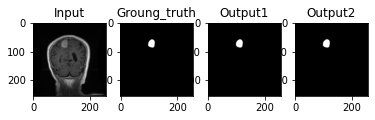

In [ ]:
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Input")
plt.subplot(1, 4, 2)
plt.imshow(img_y)
plt.title("Groung_truth")
plt.subplot(1,4,3)
plt.imshow(y_pred_1*255,cmap='gray')
plt.title("Output1")
plt.subplot(1,4,4)
plt.imshow(y_pred_2*255,cmap='gray')
plt.title("Output2")

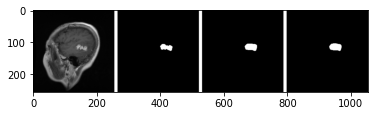

In [ ]:
x=cv2.imread("/content/output/0.png")
plt.imshow(x)

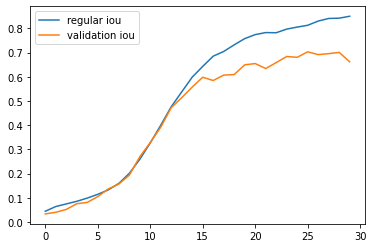

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
x=pd.read_csv("/content/files/Double_UNET_data.csv")
epoch=x.iloc[:,0:1].values
regular_iou=x.iloc[:,3:4].values
val_iou=x.iloc[:,10:11].values 
plt.plot(epoch,regular_iou,label='regular iou')
plt.plot(epoch,val_iou,label='validation iou')
plt.legend()
plt.show()